##### Sprintの目的
- 自然言語処理の一連の流れを学ぶ
- 自然言語のベクトル化の方法を学ぶ

##### 自然言語処理により何ができるか
機械学習の入力や出力に自然言語のテキストを用いることで様々なことができます。入力も出力もテキストである例としては 機械翻訳 があげられ、実用化されています。入力は画像で出力がテキストである 画像キャプション生成 やその逆の文章からの画像生成も研究が進んでいます。


しかし、出力をテキストや画像のような非構造化データとすることは難易度が高いです。比較的簡単にできることとしては、入力をテキスト、出力をカテゴリーとする テキスト分類 です。


アヤメやタイタニック、手書き数字のような定番の存在として、IMDB映画レビューデータセット の感情分析があります。レビューの文書が映画に対して肯定的か否定的かを2値分類します。文書ごとの肯定・否定はラベルが与えられています。このSprintではこれを使っていきます。

#### IMDB映画レビューデータセットの準備

IMDB映画レビューデータセットを準備します。


次のwgetコマンドによってダウンロードします。

[Sentiment Analysis](http://ai.stanford.edu/~amaas/data/sentiment/)

In [1]:
#wgetコマンドのインストール

#「wget」コマンドは“ノンインタラクティブなダウンローダー”です。
#「wget URL」で指定したURLのファイルをダウンロードします。

#!brew install wget

In [2]:
# IMDBをカレントフォルダにダウンロード
#!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
# 解凍
#!tar zxf aclImdb_v1.tar.gz
# aclImdb/train/unsupはラベル無しのため削除
#!rm -rf aclImdb/train/unsup
# IMDBデータセットの説明を表示
!cat aclImdb/README

Large Movie Review Dataset v1.0

Overview

This dataset contains movie reviews along with their associated binary
sentiment polarity labels. It is intended to serve as a benchmark for
sentiment classification. This document outlines how the dataset was
gathered, and how to use the files provided. 

Dataset 

The core dataset contains 50,000 reviews split evenly into 25k train
and 25k test sets. The overall distribution of labels is balanced (25k
pos and 25k neg). We also include an additional 50,000 unlabeled
documents for unsupervised learning. 

In the entire collection, no more than 30 reviews are allowed for any
given movie because reviews for the same movie tend to have correlated
ratings. Further, the train and test sets contain a disjoint set of
movies, so no significant performance is obtained by memorizing
movie-unique terms and their associated with observed labels.  In the
labeled train/test sets, a negative review has a score <= 4 out of 10,
and a positive review has a scor

scikit-learnのload_filesを用いて読み込みます。


[sklearn.datasets.load_files — scikit-learn 0.21.3 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_files.html)

In [3]:
from sklearn.datasets import load_files

train_review = load_files('./aclImdb/train/', encoding='utf-8')
x_train, y_train = train_review.data, train_review.target
test_review = load_files('./aclImdb/test/', encoding='utf-8')
x_test, y_test = test_review.data, test_review.target
# ラベルの0,1と意味の対応の表示
print(train_review.target_names)

['neg', 'pos']


In [4]:
print(type(x_train))
print(type(y_train))

<class 'list'>
<class 'numpy.ndarray'>


In [5]:
print(x_train[0])
print("-------------------------")
print(y_train)

Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.<br /><br />It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see. <br /><br />Flawed but honest with a terrible honesty.
-------------------------
[1 0 1 ... 0 0 0]


In [6]:
print(len(x_train))
print(len(x_test))
print(y_train.shape)

25000
25000
(25000,)


**x_trainが文章データ、y_trainがラベル**

IMDBはInternet Movie Databaseの略で、映画のデータベースサイトです。


[Ratings and Reviews for New Movies and TV Shows - IMDb](https://www.imdb.com/)


このサイトではユーザーが映画に対して1から10点の評価とコメントを投稿することができます。そのデータベースから訓練データは25000件、テストデータは25000件のデータセットを作成しています。


4点以下を否定的、7点以下を肯定的なレビューとして2値のラベル付けしており、これにより感情の分類を行います。5,6点の中立的なレビューはデータセットに含んでいません。また、ラベルは訓練用・テスト用それぞれで均一に入っています。詳細はダウンロードしたREADMEを確認してください。

## 古典的な手法

古典的ながら現在でも強力な手法であるBoWとTF-IDFを見ていきます。

### BoW

単純ながら効果的な方法として BoW (Bag of Words) があります。これは、サンプルごとに単語などの 登場回数 を数えたものをベクトルとする方法です。単語をカテゴリとして捉え one-hot表現 していることになります。

例として、IMDBデータセットからある3文の最初の5単語を抜き出したものを用意しました。

#### 例

In [7]:
mini_dataset = \
  ["This movie is very good.",
  "This film is a good",
  "Very bad. Very, very bad."]

この3文にBoWを適用させてみます。scikit-learnのCountVectorizerを利用します。

[sklearn.feature_extraction.text.CountVectorizer — scikit-learn 0.21.3 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

In [8]:
#文章中に出てくる単語について何回使用されたかをカウント
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(token_pattern=r'(?u)\b\w+\b')
bow = (vectorizer.fit_transform(mini_dataset)).toarray()
# DataFrameにまとめる
df = pd.DataFrame(bow, columns=vectorizer.get_feature_names())
display(df)

,a,bad,film,good,is,movie,this,very
0,0,0,0,1,1,1,1,1
1,1,0,1,1,1,0,1,0
2,0,2,0,0,0,0,0,3


例にあげた3文の中で登場する8種類の単語が列名になり、0,1,2番目のサンプルでそれらが何回登場しているかを示しています。2番目のサンプル「Very bad. Very, very bad.」ではbadが2回、veryが3回登場しています。列名になっている言葉はデータセットが持つ 語彙 と呼びます。


テキストはBoWにより各サンプルが語彙数の次元を持つ特徴量となり、機械学習モデルへ入力できるようになります。この時使用したテキスト全体のことを コーパス と呼びます。語彙はコーパスに含まれる言葉よって決まり、それを特徴量としてモデルの学習を行います。そのため、テストデータではじめて登場する語彙はベクトル化される際に無視されます。



#### 前処理
CountVectorizerクラスでは大文字は小文字に揃えるという 前処理 が自動的に行われています。こういった前処理は自然言語処理において大切で、不要な記号などの消去（テキストクリーニング）や表記揺れの統一といったことを別途行うことが一般的です。


語形が「see」「saw」「seen」のように変化する単語に対して語幹に揃える ステミング と呼ばれる処理を行うこともあります。

#### トークン
BoWは厳密には単語を数えているのではなく、 トークン（token） として定めた固まりを数えます。


何をトークンとするかはCountVectorizerでは引数token_patternで 正規表現 の記法により指定されます。デフォルトはr'(?u)\b\w\w+\b'ですが、上の例ではr'(?u)\b\w+\b'としています。


デフォルトでは空白・句読点・スラッシュなどに囲まれた2文字以上の文字を1つのトークンとして抜き出すようになっているため、「a」や「I」などがカウントされません。英語では1文字の単語は文章の特徴をあまり表さないため、除外されることもあります。しかし、上の例では1文字の単語もトークンとして抜き出すように引数を指定しています。


《正規表現》


正規表現は前処理の際にも活用しますが、ここでは詳細は扱いません。Pythonではreモジュールによって正規表現操作ができます。


[re — 正規表現操作](https://docs.python.org/ja/3/library/re.html)


正規表現を利用する際はリアルタイムで結果を確認できる以下のようなサービスが便利です。


[Online regex tester and debugger: PHP, PCRE, Python, Golang and JavaScript](https://regex101.com/)

正規表現　＝　正規表現とは、文字列を1つのパターン化した文字列で表現する表記法

#### 形態素解析
英語などの多くの言語では空白という分かりやすい基準でトークン化が行えますが、日本語ではそれが行えません。


日本語では名詞や助詞、動詞のように異なる 品詞 で分けられる単位で 分かち書き することになります。例えば「私はプログラミングを学びます」という日本語の文は「私/は/プログラミング/を/学び/ます」という風になります。


これには MeCab や Janome のような形態素解析ツールを用います。Pythonから利用することも可能です。MeCabをウェブ上で簡単に利用できるWeb茶まめというサービスも国立国語研究所が提供しています。


自然言語では新しい言葉も日々生まれますので、それにどれだけ対応できるかも大切です。MeCab用の毎週更新される辞書として mecab-ipadic-NEologd がオープンソースで存在しています。


[mecab-ipadic-neologd/README.ja.md at master · neologd/mecab-ipadic-neologd](https://github.com/neologd/mecab-ipadic-neologd/blob/master/README.ja.md)

#### n-gram
上のBoWの例では1つの単語（トークン）毎の登場回数を数えましたが、これでは語順は全く考慮されていません。


考慮するために、隣あう単語同士をまとめて扱う n-gram という考え方を適用することがあります。2つの単語をまとめる場合は 2-gram (bigram) と呼び、次のようになります。

In [9]:
mini_dataset = \
  ["This movie is very good.",
  "This film is a good",
  "Very bad. Very, very bad."]

In [10]:
# ngram_rangeで利用するn-gramの範囲を指定する
vectorizer = CountVectorizer(ngram_range=(2, 2), token_pattern=r'(?u)\b\w+\b')
bow_train = (vectorizer.fit_transform(mini_dataset)).toarray()
df = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names())
display(df)

,a good,bad very,film is,is a,is very,movie is,this film,this movie,very bad,very good,very very
0,0,0,0,0,1,1,0,1,0,1,0
1,1,0,1,1,0,0,1,0,0,0,0
2,0,1,0,0,0,0,0,0,2,0,1


2-gramにより「very good」と「very bad」が区別して数えられています。


単語をまとめない場合は 1-gram (unigram) と呼びます。3つまとめる3-gram(trigram)など任意の数を考えることができます。1-gramと2-gramを組み合わせてBoWを行うといったこともあります。

#### 【問題1】BoWのスクラッチ実装
以下の3文のBoWを求められるプログラムをscikit-learnを使わずに作成してください。1-gramと2-gramで計算してください。

This movie is SOOOO funny!!!  
What a movie! I never  
best movie ever!!!!! this movie

In [11]:
corpus = \
  ["This movie is SOOOO funny!!!",
  "What a movie! I never",
  "best movie ever!!!!! this movie"]

**1-gramの場合**

In [12]:
#行データのみのデータフレーム作成
df = pd.DataFrame(index=range(len(corpus)))
display(df)
print("---------------")


for i, text in enumerate(corpus):
    text = text.lower() #小文字に
    text = text.replace("!", "") #！消す
    words = text.split(" ") #分割 & リスト化
    for word in words:
        if word not in df.columns:
            df[word] = 0
        df.loc[i, word] += 1

display(df)

""
0
1
2


---------------


,this,movie,is,soooo,funny,what,a,i,never,best,ever
0,1,1,1,1,1,0,0,0,0,0,0
1,0,1,0,0,0,1,1,1,1,0,0
2,1,2,0,0,0,0,0,0,0,1,1


**2-gramの場合**  
[Pythonで文字列を連結・結合（+演算子、joinなど）](https://note.nkmk.me/python-string-concat/)

In [13]:
n_gram = 2

#行データのみのデータフレーム作成
df = pd.DataFrame(index=range(len(corpus)))

for i, text in enumerate(corpus):
    join_words_list = [] #結合した単語の保存用リスト
    
    text = text.lower() #小文字に
    text = text.replace("!", "") #！消す
    words = text.split(" ") #分割 & リスト化
    for j in range(len(words) - 1):
        join_words = " ".join(words[j : j+n_gram])
        join_words_list.append(join_words)
        
    for join_word in join_words_list:
        if join_word not in df.columns:
            df[join_word] = 0
        df.loc[i, join_word] += 1

display(df)

,this movie,movie is,is soooo,soooo funny,what a,a movie,movie i,i never,best movie,movie ever,ever this
0,1,1,1,1,0,0,0,0,0,0,0
1,0,0,0,0,1,1,1,1,0,0,0
2,1,0,0,0,0,0,0,0,1,1,1


### TF-IDF
BoWの発展的手法として TF-IDF もよく使われます。これは Term Frequency (TF) と Inverse Document Frequency (IDF) という2つの指標の組み合わせです。  
TF：文章内の単語の総数  
IDF：全文章中での単語の出現頻度

#### IDF
IDFはそのトークンがデータセット内で珍しいほど値が大きくなる指標です。


サンプル数 $N$ をIMDB映画レビューデータセットの訓練データに合わせ25000として、トークンが出現するサンプル数 $df(t)$ を変化させたグラフを確認してみると、次のようになります。

In [14]:
import numpy as np
import matplotlib.pyplot as plt
n_samples = 25000
idf = np.log(n_samples/np.arange(1,n_samples))
plt.title("IDF")
plt.xlabel("df(t)")
plt.ylabel("IDF")
plt.plot(idf)
plt.show()

<Figure size 640x480 with 1 Axes>

TF-IDFではこの数を出現回数に掛け合わせるので、珍しいトークンの登場に重み付けを行なっていることになります。

#### ストップワード
あまりにも頻繁に登場するトークンは、値を小さくするだけでなく、取り除くという前処理を加えることもあります。取り除くもののことを ストップワード と呼びます。既存のストップワード一覧を利用したり、しきい値によって求めたりします。


scikit-learnのCountVectorizerでは引数stop_wordsにリストで指定することで処理を行なってくれます。



In [15]:
vectorizer = CountVectorizer(stop_words=["is"], token_pattern=r'\b\w+\b')
bow_train = (vectorizer.fit_transform(mini_dataset)).toarray()
df = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names())
display(df)

,a,bad,film,good,movie,this,very
0,0,0,0,1,1,1,1
1,1,0,1,1,0,1,0
2,0,2,0,0,0,0,3


代表的な既存のストップワード一覧としては、NLTK という自然言語処理のライブラリのものがあげられます。あるデータセットにおいては特別重要な意味を持つ単語が一覧に含まれている可能性もあるため、使用する際は中身を確認することが望ましいです。

In [16]:
# はじめて使う場合はストップワードをダウンロード
import nltk
stop_words = nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
print("stop word : {}".format(stop_words)) # 'i', 'me', 'my', ...

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/itonaoki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
stop word : ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'w

逆に、登場回数が特に少ないトークンも取り除くことが多いです。全てのトークンを用いるとベクトルの次元数が著しく大きくなってしまい計算コストが高まるためです。


scikit-learnのCountVectorizerでは引数max_featuresに最大の語彙数を指定することで処理を行なってくれます。以下の例では出現数が多い順に5個でベクトル化しています。

In [17]:
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b', max_features = 5)
bow_train = (vectorizer.fit_transform(mini_dataset)).toarray()
df = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names())
display(df)

,bad,good,is,this,very
0,0,1,1,1,1
1,0,1,1,1,0
2,2,0,0,0,3


#### 【問題2】TF-IDFの計算
IMDB映画レビューデータセットをTF-IDFによりベクトル化してください。NLTKのストップワードを利用し、最大の語彙数は5000程度に設定してください。テキストクリーニングやステミングなどの前処理はこの問題では要求しません。


TF-IDFの計算にはscikit-learnの以下のどちらかのクラスを使用してください。


[sklearn.feature_extraction.text.TfidfVectorizer — scikit-learn 0.21.3 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)
[sklearn.feature_extraction.text.TfidfTransformer — scikit-learn 0.21.3 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)


なお、scikit-learnでは標準的な式とは異なる式が採用されています。


また、デフォルトではnorm="l2"の引数が設定されており、各サンプルにL2正規化が行われます。norm=Noneとすることで正規化は行われなくなります。

Term Frequency:
$$
tf(t, d) = n_{t, d}
$$

$n_{t, d}$ : サンプルd内のトークンtの出現回数


scikit-learnのTFは分母がなくなりBoWと同じ計算になります。

Inverse Document Frequency:
$$
idf(t) = log\frac{1 + N}{1 + df(t)} + 1
$$

$N$ : サンプル数

$df(t)$ : トークンtが出現するサンプル数

※logの底はネイピア数e

[5.2.3.4. Tf–idf term weighting — scikit-learn 0.21.3 documentation](https://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting)

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=5000, token_pattern=r'(?u)\b\w+\b')
X_train = vectorizer.fit_transform(x_train).toarray()
X_test = vectorizer.fit_transform(x_test).toarray()
cols = vectorizer.get_feature_names()
df = pd.DataFrame(X_train, columns=cols)
display(df)

,0,00,000,1,10,100,11,12,13,13th,...,young,younger,youth,z,zellweger,zero,zoey,zombie,zombies,zone
0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.164505,0.0,0.000000,0.0,0.136932,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.000000,0.124442,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.000000,0.085006,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
5,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
6,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
7,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
8,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.035996,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
9,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0


In [19]:
print(X_train.shape)
print(X_test.shape)

(25000, 5000)
(25000, 5000)


In [20]:
vectorizer.vocabulary_

{'hate': 2077,
 'graham': 1973,
 'beautiful': 435,
 'fun': 1870,
 'watch': 4840,
 'movie': 2948,
 'like': 2616,
 'hip': 2141,
 'clothing': 863,
 'surroundings': 4361,
 'actors': 121,
 'flick': 1774,
 'work': 4945,
 'well': 4870,
 'together': 4531,
 'casey': 711,
 'hysterical': 2232,
 'literally': 2637,
 'lights': 2614,
 'screen': 3879,
 'minor': 2877,
 'characters': 765,
 'patricia': 3232,
 'talented': 4397,
 'gorgeous': 1962,
 'director': 1286,
 'lisa': 2631,
 'know': 2503,
 'received': 3596,
 'many': 2747,
 'positive': 3373,
 'comments': 913,
 'one': 3132,
 'call': 651,
 'artistic': 320,
 'beautifully': 436,
 'filmed': 1733,
 'things': 4481,
 'make': 2729,
 'empty': 1480,
 'plot': 3336,
 'filled': 1730,
 'sexual': 3954,
 'wish': 4915,
 'wasted': 4838,
 'time': 4520,
 'rather': 3565,
 'poor': 3354,
 'excuse': 1584,
 'strange': 4258,
 'behavior': 449,
 'another': 263,
 'hollywood': 2166,
 'attempt': 350,
 'convince': 1001,
 'us': 4718,
 'kind': 2491,
 'life': 2607,
 'normal': 3060,
 'o

In [21]:
# 2-gram
vectorizer2 = TfidfVectorizer(stop_words=stop_words, max_features=5000, ngram_range=(2, 2), token_pattern=r'(?u)\b\w+\b')
X_train2 = vectorizer.fit_transform(x_train).toarray()
X_test2 = vectorizer.fit_transform(x_train).toarray()

In [22]:
print(X_train2.shape)
print(X_test2.shape)

(25000, 5000)
(25000, 5000)


#### 【問題3】TF-IDFを用いた学習
問題2で求めたベクトルを用いてIMDB映画レビューデータセットの学習・推定を行なってください。モデルは2値分類が行える任意のものを利用してください。


ここでは精度の高さは求めませんが、最大の語彙数やストップワード、n-gramの数を変化させて影響を検証してみてください。

In [23]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

clf = SGDClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("accuracy", accuracy_score(y_test, y_pred))

/Users/itonaoki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


accuracy 0.51632


In [24]:
#2-gram
clf2 = SGDClassifier()
clf.fit(X_train2, y_train)
y_pred2 = clf.predict(X_test2)
print("accuracy", accuracy_score(y_test, y_pred2))

/Users/itonaoki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


accuracy 0.9194


#### 【問題4】TF-IDFのスクラッチ実装
以下の3文のTF-IDFを求められるプログラムをscikit-learnを使わずに作成してください。標準的な式と、scikit-learnの採用している式の2種類を作成してください。正規化は不要です。

This movie is SOOOO funny!!!  
What a movie! I never  
best movie ever!!!!! this movie

In [25]:
corpus

['This movie is SOOOO funny!!!',
 'What a movie! I never',
 'best movie ever!!!!! this movie']

In [26]:
#標準的な式

df = pd.DataFrame(index=range(len(corpus)))

for i, text in enumerate(corpus):
    text = text.lower() #小文字に
    text = text.replace("!", "") #！消す
    words = text.split(" ") #分割 & リスト化
    for word in words:
        if word not in df.columns:
            df[word] = 0
        df.loc[i, word] += 1

display(df)


N = df.shape[0] #サンプル数
idf_dic = {}
for word in df.columns:
    idf_dic[word] = np.log(N/(df[word]>0).sum())
print(idf_dic)
    
for j in range(N):
    token_num = np.sum(df.loc[j, :])
    for word in df.columns:
        df.loc[j, word] = (df.loc[j, word]/token_num) * idf_dic[word]

display(df)

,this,movie,is,soooo,funny,what,a,i,never,best,ever
0,1,1,1,1,1,0,0,0,0,0,0
1,0,1,0,0,0,1,1,1,1,0,0
2,1,2,0,0,0,0,0,0,0,1,1


{'this': 0.4054651081081644, 'movie': 0.0, 'is': 1.0986122886681098, 'soooo': 1.0986122886681098, 'funny': 1.0986122886681098, 'what': 1.0986122886681098, 'a': 1.0986122886681098, 'i': 1.0986122886681098, 'never': 1.0986122886681098, 'best': 1.0986122886681098, 'ever': 1.0986122886681098}


,this,movie,is,soooo,funny,what,a,i,never,best,ever
0,0.081093,0.0,0.219722,0.219722,0.219722,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.0,0.000000,0.000000,0.000000,0.219722,0.219722,0.219722,0.219722,0.000000,0.000000
2,0.081093,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.219722,0.219722


全文書に登場する単語のTF-IDFが強制的に0になってしまう

In [27]:
#scikit-learnの式

df = pd.DataFrame(index=range(len(corpus)))

for i, text in enumerate(corpus):
    text = text.lower() #小文字に
    text = text.replace("!", "") #！消す
    words = text.split(" ") #分割 & リスト化
    for word in words:
        if word not in df.columns:
            df[word] = 0
        df.loc[i, word] += 1

display(df)

N = df.shape[0] #サンプル数
idf_dic = {}
for word in df.columns:
    idf_dic[word] = np.log((1 + N)/(1 + (df[word]>0).sum())) + 1
print(idf_dic)

for j in range(N):
    token_num = np.sum(df.loc[j, :])
    for word in df.columns:
        df.loc[j, word] = df.loc[j, word] * idf_dic[word]

display(df)

,this,movie,is,soooo,funny,what,a,i,never,best,ever
0,1,1,1,1,1,0,0,0,0,0,0
1,0,1,0,0,0,1,1,1,1,0,0
2,1,2,0,0,0,0,0,0,0,1,1


{'this': 1.2876820724517808, 'movie': 1.0, 'is': 1.6931471805599454, 'soooo': 1.6931471805599454, 'funny': 1.6931471805599454, 'what': 1.6931471805599454, 'a': 1.6931471805599454, 'i': 1.6931471805599454, 'never': 1.6931471805599454, 'best': 1.6931471805599454, 'ever': 1.6931471805599454}


,this,movie,is,soooo,funny,what,a,i,never,best,ever
0,1.287682,1.0,1.693147,1.693147,1.693147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,1.0,0.000000,0.000000,0.000000,1.693147,1.693147,1.693147,1.693147,0.000000,0.000000
2,1.287682,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.693147,1.693147


全文書に登場する単語のTF-IDFが強制的に0になってしまうのを回避できている

### Word2Vec

ニューラルネットワークを用いてベクトル化を行う手法が Word2Vec です。


BoWやTF-IDFはone-hot表現であったため、得られるベクトルの次元は語彙数分になります。そのため、語彙数を増やしにくいという問題があります。一方で、Word2Vecでは単語を任意の次元のベクトルに変換します。これをを Word Embedding（単語埋め込み） や 分散表現 と呼びます。変換操作を「ベクトル空間に埋め込む」と言うことが多いです。


Word2VecにはCBoWとSkip-gramという2種類の仕組みがあるため順番に見ていきます。



#### CBoW
CBoW (Continuous Bag-of-Words) によるWord2Vecではある単語とある単語の間に来る単語を推定できるように全結合層2層のニューラルネットワークを学習します。


単語はコーパスの語彙数次元のone-hot表現を行なっておきます。そのため、入力と出力の次元は語彙数と同じになります。一方で、中間のノード数をWord2Vecにより得たい任意の次元数とします。これにより全結合層の重みは「得たい次元のノード数×語彙数」になります。このネットワークにより学習を行なった後、出力側の重みを取り出すことで、各語彙を表すベクトルを手に入れることができます。


間の単語の推定を行なっているため、同じ箇所で代替可能な言葉は似たベクトルになるというメリットもあります。これはBoWやTF-IDFでは得られない情報です。


あるテキストは「そのテキストの長さ（単語数）×Word2Vecで得た分散表現の次元数」の配列になりますが、各入力の配列を揃える必要があるモデルに入力するためには、短いテキストは空白を表す単語を加える パディング を行なったり、長いテキストは単語を消したりします。テキストを 固定長 にすると呼びます。

##### ウィンドウサイズ
入力する単語は推定する前後1つずつだけでなく、複数個とする場合もあります。前後いくつを見るかの大きさを ウィンドウサイズ と呼びます。


##### Skip-gram
CBoWとは逆にある単語の前後の単語を推定できるように全結合層2層のニューラルネットワークを学習する方法が Skip-gram です。学習を行なった後は入力側の重みを取り出し各語彙を表すベクトルとします。現在一般的に使われているのはCBoWよりもSki-gramです。


##### 利用方法
Pythonでは Gensim ライブラリを用いて扱うことができます。


[gensim: models.word2vec – Word2vec embeddings](https://radimrehurek.com/gensim/models/word2vec.html)


BoWの例と同じ文章で学習してみます。CountVectorizerと異なり前処理を自動的に行なってはくれないため、単語（トークン）はリストで分割しておきます。また、大文字は小文字に揃え、記号は取り除きます。


デフォルトのパラメータではCBoWで計算されます。また、ウィンドウサイズはwindow=5に設定されています。

In [28]:
from gensim.models import Word2Vec
sentences = [['this', 'movie', 'is', 'very', 'good'], ['this', 'film', 'is', 'a', 'good'], ['very', 'bad', 'very', 'very', 'bad']]
model = Word2Vec(min_count=1, size=10) # 次元数を10に設定
model.build_vocab(sentences) # 準備
model.train(sentences, total_examples=model.corpus_count, epochs=model.iter) # 学習
print("語彙の一覧 : {}".format(model.wv.vocab.keys()))
for vocab in model.wv.vocab.keys():
    print("{}のベクトル : \n{}".format(vocab, model.wv[vocab]))

語彙の一覧 : dict_keys(['this', 'movie', 'is', 'very', 'good', 'film', 'a', 'bad'])
thisのベクトル : 
[ 0.02365869  0.01886323  0.04146154  0.04979543  0.01740373  0.0331458
 -0.02010566 -0.030622    0.00138941 -0.03772479]
movieのベクトル : 
[-0.00515686  0.04369088  0.0420732  -0.02897665 -0.01872913 -0.00971327
  0.00768237 -0.03534362 -0.03133305 -0.00465968]
isのベクトル : 
[ 0.00457812 -0.0066611   0.02874527 -0.0370437   0.02399253  0.04535765
 -0.03786702  0.01229602  0.03732948  0.04804269]
veryのベクトル : 
[ 0.04414469 -0.00664242 -0.00087459  0.01801981 -0.00988795 -0.04676831
  0.00826601  0.02250074  0.01416051 -0.02492178]
goodのベクトル : 
[ 0.01435657  0.0199935  -0.03111928  0.04428221 -0.00873459 -0.04095155
 -0.01677543  0.01484518 -0.02207142  0.04147479]
filmのベクトル : 
[ 0.0323323  -0.01237822  0.03803379  0.04172546 -0.04646122 -0.0227507
 -0.03762242 -0.02792635  0.01614347  0.04127774]
aのベクトル : 
[-0.00560524 -0.02327583 -0.01647522  0.00833912 -0.02729021 -0.03370345
 -0.03917094 -0.03654372 

/Users/itonaoki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  """


##### 単語の距離
ベクトル間で計算を行うことで、ある単語に似たベクトルを持つ単語を見つけることができます。例えばgoodに似たベクトルの単語を3つ探します。

In [29]:
model.wv.most_similar(positive="good", topn=3)

[('film', 0.40011265873908997),
 ('very', 0.3142697811126709),
 ('bad', 0.19806697964668274)]

今の例では3文しか学習していませんので効果を発揮しませんが、大きなコーパスで学習することで、並列関係のものが近くに来たりなど面白い結果が得られます。

##### 可視化
2次元に圧縮することで単語ごとの位置関係を可視化することができます。以下はt-SNEを用いた例です。



/Users/itonaoki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


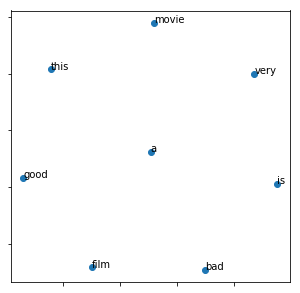

In [30]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
vocabs = model.wv.vocab.keys()
tsne_model = TSNE(perplexity=40, n_components=2, init="pca", n_iter=5000, random_state=23)
vectors_tsne = tsne_model.fit_transform(model[vocabs])
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(vectors_tsne[:, 0], vectors_tsne[:, 1])
for i, word in enumerate(list(vocabs)):
    plt.annotate(word, xy=(vectors_tsne[i, 0], vectors_tsne[i, 1]))
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.show()

### IMDB映画レビューデータセットの分散表現

IMDB映画レビューデータセットの訓練データをコーパスとしてWord2Vecを学習させ分散表現を獲得しましょう。

#### 【問題5】コーパスの前処理
コーパスの前処理として、特殊文字（!など）やURLの除去、大文字の小文字化といったことを行なってください。また、単語（トークン）はリストで分割してください。

In [31]:
from sklearn.datasets import load_files

train_review = load_files('./aclImdb/train/', encoding='utf-8')
x_train, y_train = train_review.data, train_review.target
test_review = load_files('./aclImdb/test/', encoding='utf-8')
x_test, y_test = test_review.data, test_review.target
# ラベルの0,1と意味の対応の表示
print(train_review.target_names)

['neg', 'pos']


In [32]:
x_train[0]

"Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.<br /><br />It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see. <br /><br />Flawed but honest with a terrible honesty."

In [33]:
import re 

preprocess_x = x_train
for i in range(len(x_train)):
    temp = preprocess_x[i].lower()
    temp = temp.replace("<br />", "").strip()
    temp = re.sub(r"(https?|ftp)(:\/\/[-_\.!~*\'()a-zA-Z0-9;\/?:\@&=\+$,%#]+)", "" ,temp)
    temp = re.sub(r'[!"#$%&\'\\\\()*+,-./:;<=>?@[\\]^_`{|}~「」〔〕“”〈〉『』【】＆＊・（）＄＃＠。、？！｀＋￥％]', "" ,temp)
    temp = temp.split()
    preprocess_x[i] = temp

In [34]:
preprocess_x[0]

['zero',
 'day',
 'leads',
 'you',
 'to',
 'think,',
 'even',
 're-think',
 'why',
 'two',
 'boys/young',
 'men',
 'would',
 'do',
 'what',
 'they',
 'did',
 '-',
 'commit',
 'mutual',
 'suicide',
 'via',
 'slaughtering',
 'their',
 'classmates.',
 'it',
 'captures',
 'what',
 'must',
 'be',
 'beyond',
 'a',
 'bizarre',
 'mode',
 'of',
 'being',
 'for',
 'two',
 'humans',
 'who',
 'have',
 'decided',
 'to',
 'withdraw',
 'from',
 'common',
 'civility',
 'in',
 'order',
 'to',
 'define',
 'their',
 'own/mutual',
 'world',
 'via',
 'coupled',
 'destruction.it',
 'is',
 'not',
 'a',
 'perfect',
 'movie',
 'but',
 'given',
 'what',
 'money/time',
 'the',
 'filmmaker',
 'and',
 'actors',
 'had',
 '-',
 'it',
 'is',
 'a',
 'remarkable',
 'product.',
 'in',
 'terms',
 'of',
 'explaining',
 'the',
 'motives',
 'and',
 'actions',
 'of',
 'the',
 'two',
 'young',
 'suicide/murderers',
 'it',
 'is',
 'better',
 'than',
 "'elephant'",
 '-',
 'in',
 'terms',
 'of',
 'being',
 'a',
 'film',
 'that',

In [35]:
preprocess_x_test = x_test
for i in range(len(x_test)):
    temp = preprocess_x_test[i].lower()
    temp = temp.replace("<br />", "").strip()
    temp = re.sub(r"(https?|ftp)(:\/\/[-_\.!~*\'()a-zA-Z0-9;\/?:\@&=\+$,%#]+)", "" ,temp)
    temp = re.sub(r'[!"#$%&\'\\\\()*+,-./:;<=>?@[\\]^_`{|}~「」〔〕“”〈〉『』【】＆＊・（）＄＃＠。、？！｀＋￥％]', "" ,temp)
    temp = temp.split()
    preprocess_x_test[i] = temp

#### 【問題6】Word2Vecの学習
Word2Vecの学習を行なってください。

In [36]:
from gensim.models import Word2Vec
sentences = preprocess_x
model = Word2Vec(min_count=1, size=10) # 次元数を10に設定
model.build_vocab(sentences) # 準備
model.train(sentences, total_examples=model.corpus_count, epochs=model.iter) # 学習

/Users/itonaoki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  """


(22250705, 28713375)

#### 【問題7】（アドバンス課題）ベクトルの可視化
得られたベクトルをt-SNEにより可視化してください。また、いくつかの単語を選びwv.most_similarを用いて似ている単語を調べてください。

In [37]:
model.wv.most_similar(positive="bad", topn=3)

[('funny', 0.9667276740074158),
 ('bad,', 0.9565809965133667),
 ('scary', 0.9554940462112427)]

In [38]:
model.wv.most_similar(positive="friends", topn=3)

[('rock-stars', 0.9612486958503723),
 ('her."', 0.9555264115333557),
 ('share.jim', 0.9513508677482605)]

コーパスの前処理が不十分そうではある

In [42]:
vocabs = model.wv.vocab.keys()
tsne_model = TSNE(perplexity=40, n_components=2, init="pca", n_iter=250, random_state=23)
vectors_tsne = tsne_model.fit_transform(model[vocabs])
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(vectors_tsne[:, 0], vectors_tsne[:, 1])
for i, word in enumerate(list(vocabs)):
    plt.annotate(word, xy=(vectors_tsne[i, 0], vectors_tsne[i, 1]))
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.show()

/Users/itonaoki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


KeyboardInterrupt: 

計算時間が長すぎるため、手動でストップ